In [1]:
!apt update -y
!apt install -y postgis

Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


In [2]:
!pip install shapely geopandas requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 113.7 MB/s eta 0:00:00


In [6]:
import requests
import json
import time

start = "2.1587391884631675,48.71051437658316"
end = "2.1526631704506567,48.720160177604434"

response = requests.get(f"http://router.project-osrm.org/route/v1/driving/{start};{end}?overview=full&geometries=geojson")
data = response.json()

route_coordinates = data["routes"][0]["geometry"]["coordinates"]

data = []

for coord in route_coordinates:
    lng, lat = coord
    data.append({
        'lng': lng,
        'lat': lat
    })

print(f"Running at :", data[:5])


[(2.158691, 48.710585),
 (2.158611, 48.710562),
 (2.158354, 48.710505),
 (2.158071, 48.710455),
 (2.157807, 48.710426)]

In [7]:
coordinates=[]
for entry in data:
  coordinates.append((entry['lng'], entry['lat']))

coordinates[0:5]

[(2.158691, 48.710585),
 (2.158611, 48.710562),
 (2.158354, 48.710505),
 (2.158071, 48.710455),
 (2.157807, 48.710426)]

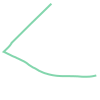

In [8]:
from shapely.geometry import LineString

line = LineString(coordinates)

line

In [9]:
import geopandas as gpd
from shapely.geometry import Point

gdf_points = gpd.GeoDataFrame(geometry=[Point(xy) for xy in coordinates], crs='EPSG:4326')

gdf_points.head()

,geometry
0,POINT (2.15869 48.71059)
1,POINT (2.15861 48.71056)
2,POINT (2.15835 48.71050)
3,POINT (2.15807 48.71046)
4,POINT (2.15781 48.71043)


In [10]:
!mkdir -p points/
gdf_points.to_file('points/poc_points.shp')

In [11]:
!psql -h postgis -d pocdb -U postgres -c "CREATE SCHEMA track;"

CREATE SCHEMA


In [ ]:
!shp2pgsql -I -s 4326 'points/poc_points.shp' track.route_points | psql -h postgis -d pocdb -U postgres

In [13]:
gdf_lines = gpd.GeoDataFrame(geometry=[line], crs='EPSG:4326')

gdf_lines.head()

,geometry
0,"LINESTRING (2.15869 48.71059, 2.15861 48.71056..."


In [14]:
!mkdir -p lines/
gdf_lines.to_file('lines/poc_lines.shp')

In [15]:
!shp2pgsql -I -s 4326 'lines/poc_lines.shp' track.route_lines | psql -h postgis -d pocdb -U postgres

Field fid is an FTDouble with width 11 and precision 0
Shapefile type: Arc
Postgis type: MULTILINESTRING[2]
SET
SET
BEGIN
CREATE TABLE
ALTER TABLE
                       addgeometrycolumn                       
---------------------------------------------------------------
 track.route_lines.geom SRID:4326 TYPE:MULTILINESTRING DIMS:2 
(1 row)

INSERT 0 1
CREATE INDEX
COMMIT
ANALYZE


In [16]:
!psql -h postgis -d pocdb -U postgres -c "SELECT gid, geom FROM track.route_lines;"

 gid |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     geom                         

In [17]:
!psql -h postgis -d pocdb -U postgres -c "SELECT DISTINCT ST_GeometryType(geom) FROM track.route_lines;"

  st_geometrytype   
--------------------
 ST_MultiLineString
(1 row)

